## Загрузка данных

Задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
Закон смещения Вина.
Закон Стефана-Больцмана.
Спектральный анализ.
Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

In [139]:
!pip install phik

In [140]:
import matplotlib.pyplot as plt
import pandas as pd
import phik
import torch
import torch.nn as nn

from phik import report
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [141]:
RANDOM_STATE = 222222

In [142]:
df = pd.read_csv("/datasets/6_class.csv", index_col=0)

In [143]:
df.head(10)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
5,2840,0.000650,0.1100,16.98,0,Red
6,2637,0.000730,0.1270,17.22,0,Red
7,2600,0.000400,0.0960,17.40,0,Red
8,2650,0.000690,0.1100,17.45,0,Red
9,2700,0.000180,0.1300,16.05,0,Red


In [144]:
df.describe(percentiles=[.5]).T

,count,mean,std,min,50%,max
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,5776.0000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.0705,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.7625,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,8.3130,20.06
Star type,240.0,2.500000,1.711394,0.00000,2.5000,5.00


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [146]:
display(f"Количество дублированных строк: {df.duplicated().sum()}")

'Количество дублированных строк: 0'

## Предобработка и анализ данных

### Анализ первоначальных данных

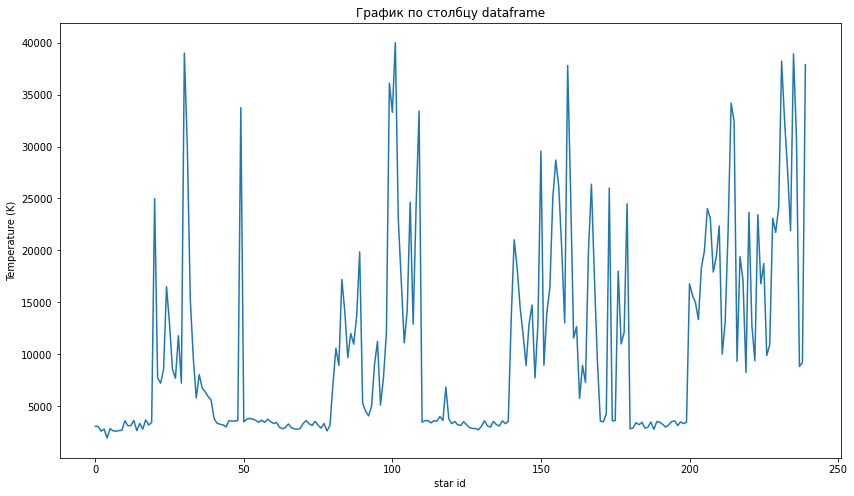

In [147]:
# Создаем график
plt.figure(figsize=(14, 8)) # Задаем размер графика

# Строим график с помощью функции plot
plt.plot(df['Temperature (K)']) # Замените 'column_name' на название вашего столбца

# Добавляем заголовок и метки осей
plt.title('График по столбцу dataframe')
plt.xlabel('star id')
plt.ylabel('Temperature (K)')

# Отображаем график
plt.show()

Звёзды делятся на разные классы и виды по температуре. Вот эти классы и виды:

Звёзды класса A — имеют небольшую температуру в 7 500–10 000 Кельвинов. Светятся белым светом.
Звёзды класса B — имеют температуру в 10 000 — 30 000 К. Светятся бело-голубым светом.
Звёзды класса F — имеют температуру в 6 000 — 7 500 К. Истинный цвет — жёлто-белый.
Звёзды класса G — имеют температуру в 5 000 — 6 000 К. Светятся жёлтым светом, как и в небе.
Звёзды класса K — имеют температуру в 3 500 — 5 000 К. Светятся оранжевым. В небе видны как жёлтовато-оранжевые.
Звёзды класса M — имеют низкую температуру в 2 000–3 500 К. Светятся красным, в небе можно увидеть их как оранжево-красные.
Звёзды класса O — имеют высокую температуру в 30 000 — 60 000 К. Светятся голубым светом, как и в небе.

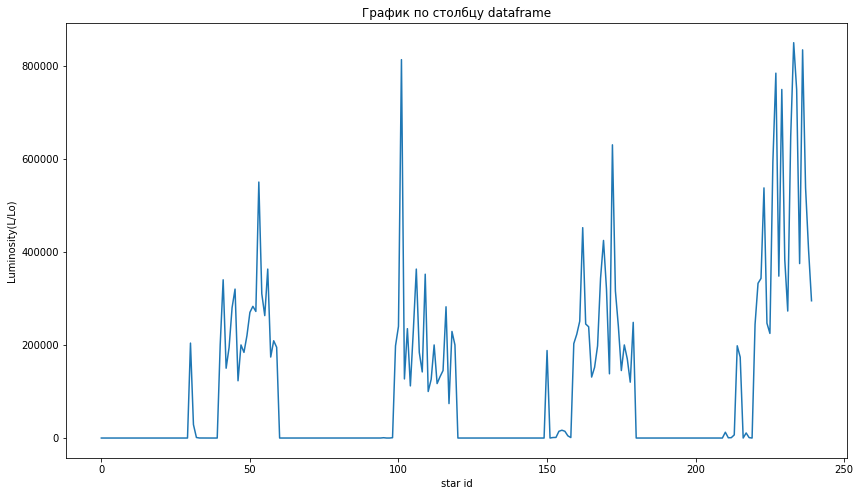

In [148]:
# Создаем график
plt.figure(figsize=(14, 8)) # Задаем размер графика

# Строим график с помощью функции plot
plt.plot(df['Luminosity(L/Lo)']) # Замените 'column_name' на название вашего столбца

# Добавляем заголовок и метки осей
plt.title('График по столбцу dataframe')
plt.xlabel('star id')
plt.ylabel('Luminosity(L/Lo)')

# Отображаем график
plt.show()

Тут делим по светимости на солнцеподобные и те, что выше солнца. Очень низкая, низкая, средняя, высокая, очень высокая

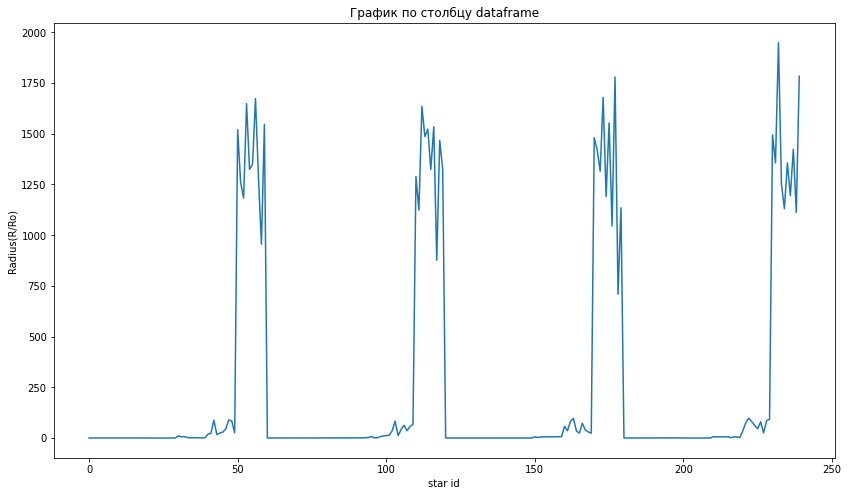

In [149]:
# Создаем график
plt.figure(figsize=(14, 8)) # Задаем размер графика

# Строим график с помощью функции plot
plt.plot(df['Radius(R/Ro)']) # Замените 'column_name' на название вашего столбца

# Добавляем заголовок и метки осей
plt.title('График по столбцу dataframe')
plt.xlabel('star id')
plt.ylabel('Radius(R/Ro)')

# Отображаем график
plt.show()

По радиусу очень маленькие, маленькие, средние, большие, очень большие 

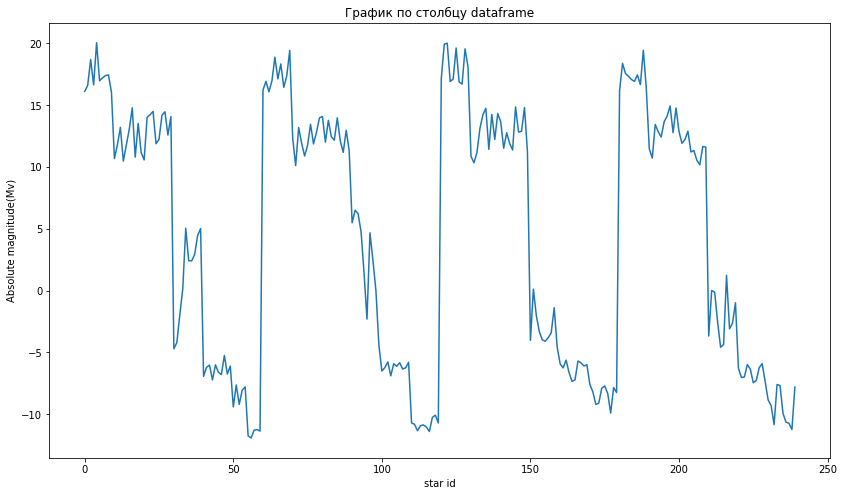

In [150]:
# Создаем график
plt.figure(figsize=(14, 8)) # Задаем размер графика

# Строим график с помощью функции plot
plt.plot(df['Absolute magnitude(Mv)']) # Замените 'column_name' на название вашего столбца

# Добавляем заголовок и метки осей
plt.title('График по столбцу dataframe')
plt.xlabel('star id')
plt.ylabel('Absolute magnitude(Mv)')

# Отображаем график
plt.show()

По магнитуде, маленькие, средние, большие, очень большие 

<AxesSubplot:>

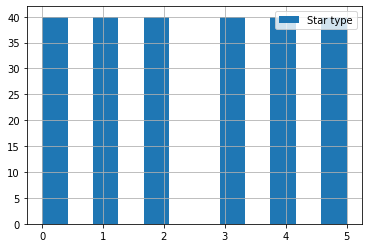

In [151]:
df['Star type'].hist(bins=12, legend=True)

In [152]:
def print_pie(grouped):
    sizes = grouped
    labels = grouped.index

    fig1, ax1 = plt.subplots(figsize=(6, 5))
    fig1.subplots_adjust(0.3,0,1.5,1)


    theme = plt.get_cmap('bwr')
    ax1.set_prop_cycle("color", [theme(1.3 * i / len(sizes)) for i in range(len(sizes))])

    ax1.pie(sizes, startangle=90)

    ax1.axis('equal')

    total = sum(sizes)
    plt.legend(
        loc='upper left',
        labels=['%s, %1.1f%%' % (
            l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
        prop={'size': 11},
        bbox_to_anchor=(0.0, 1),
        bbox_transform=fig1.transFigure
    )

    plt.show()

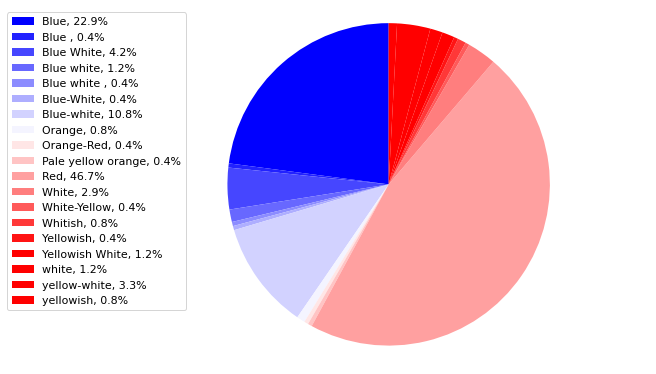

In [153]:
grouped = df.groupby('Star color').size()
print_pie(grouped)

Вывод: В категориальной переменной "Star color" много неявных дубликатов. В остальном ни выбывающихся значений, ни пропусков, ни явных дубликатов не наблюдается. Остаётся только исправиить значения колонки "Star color", построить хитмап корреляции параметров и упростить названия колонок для дальнейшей работы.

### Предобработка данных

In [154]:
# Изменим имеющиеся названия столбцов путем упрощения
df.columns = ['temp', 'luminosity', 'radius', 'magnitude', 'type', 'color']

In [155]:
# Blue
df.loc[
    df['color'] == 'Blue ',
    'color'
] = 'Blue'

# Blue and white
df.loc[
    (df['color'] == 'Blue white') | 
    (df['color'] == 'Blue-white') |
    (df['color'] == 'Blue-White') |
    (df['color'] == 'Blue white '), 
    'color'
] = 'Blue White'

# White
df.loc[
    (df['color'] == 'white') |
    (df['color'] == 'Whitish') |
    (df['color'] == 'whitish'),
    'color'
] = 'White'

# Yellow
df.loc[
    (df['color'] == 'Yellowish White') |
    (df['color'] == 'yellow-white') | 
    (df['color'] == 'White-Yellow') |
    (df['color'] == 'Yellow White') |
    (df['color'] == 'yellowish') |
    (df['color'] == 'Yellowish') |
    (df['color'] == 'Pale yellow orange'),
    'color'
] = 'Yellow'

# Orange and red
df.loc[
    (df['color'] == 'Orange-Red') |
    (df['color'] == 'Orange Red'),
    'color'
] = 'Orange'

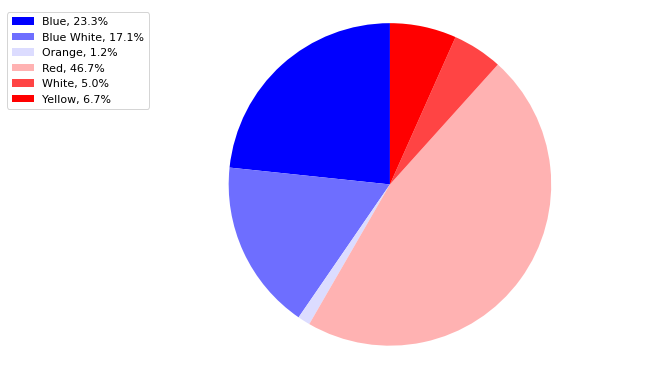

In [156]:
grouped = df.groupby('color').size()
print_pie(grouped)

interval columns not set, guessing: ['temp', 'luminosity', 'radius', 'magnitude', 'type']


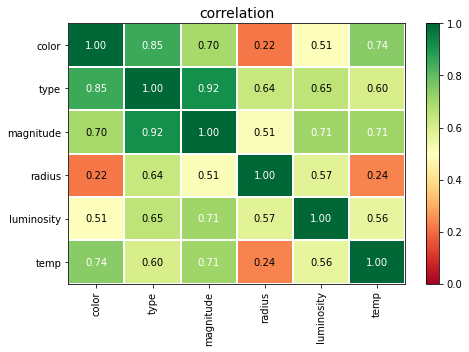

In [157]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1
)

Вывод: Была проделана комплексная работа по анализу и предобработке данных. В ходе которой были выявлены и устранены неявные дубликаты в колонке с цветом звезды, также была построена матрица корреляции. Из данной матрицы следует, что все значения мультиколлинеарны - следовательно стоит использовать методы регуляризации параметров или исключение некоторых признаков.
Целевая переменная Temperature в основном завит от цвета звезды и её магнитуды, а меньше всего опирается на размер и светимость звезды.

## Построение базовой нейронной сети

In [158]:
train = df.drop('temp', axis=1)
test = df['temp']
train

,luminosity,radius,magnitude,type,color
0,0.002400,0.1700,16.12,0,Red
1,0.000500,0.1542,16.60,0,Red
2,0.000300,0.1020,18.70,0,Red
3,0.000200,0.1600,16.65,0,Red
4,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...
235,374830.000000,1356.0000,-9.93,5,Blue
236,834042.000000,1194.0000,-10.63,5,Blue
237,537493.000000,1423.0000,-10.73,5,White
238,404940.000000,1112.0000,-11.23,5,White


In [159]:
test

0       3068
1       3042
2       2600
3       2800
4       1939
       ...  
235    38940
236    30839
237     8829
238     9235
239    37882
Name: temp, Length: 240, dtype: int64

In [160]:
categorial_columns = ['type', 'color']
numeric_columns = ['luminosity', 'radius', 'magnitude']

In [161]:
X_train, X_test, y_train, y_test = train_test_split(train, test, random_state=RANDOM_STATE)

In [162]:
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

In [163]:
encoder.fit(X_train[categorial_columns])

OneHotEncoder(handle_unknown='ignore')

In [164]:
X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[categorial_columns]).toarray(),
    columns=encoder.get_feature_names(categorial_columns),
    index=X_train.index
)
X_train_encoded = pd.concat((X_train[numeric_columns], X_train_encoded), axis=1)

In [165]:
X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[categorial_columns]).toarray(),
    columns=encoder.get_feature_names(categorial_columns),
    index=X_test.index
)
X_test_encoded = pd.concat((X_test[numeric_columns], X_test_encoded), axis=1)

In [167]:
X_train_encoded.shape

(180, 15)

In [173]:
scaler.fit(X_train_encoded)

StandardScaler()

In [174]:
X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [189]:
n_in_neurons = X_train_encoded.shape[1]
n_hidden_neurons_1 = 8
n_hidden_neurons_2 = 4
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.ReLU()
)

In [190]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.MSELoss()

num_epochs = 8001

In [176]:
X_train = torch.FloatTensor(X_train_scaled)
X_test = torch.FloatTensor(X_test_scaled)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [191]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(X_train).flatten()

    loss_value = loss(preds, y_train)

    loss_value.backward()

    optimizer.step()

    if epoch % 1000 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test).flatten()
        print('Epoch #:', epoch)
        print('RMSE =', torch.sqrt(loss(test_preds, y_test)).item(), '\n')

Epoch #: 0
RMSE = 12184.96875 

Epoch #: 1000
RMSE = 11551.7919921875 

Epoch #: 2000
RMSE = 8517.37890625 

Epoch #: 3000
RMSE = 5701.435546875 

Epoch #: 4000
RMSE = 5029.07861328125 

Epoch #: 5000
RMSE = 5022.25146484375 

Epoch #: 6000
RMSE = 5038.64990234375 

Epoch #: 7000
RMSE = 5021.49853515625 

Epoch #: 8000
RMSE = 4992.7197265625 



## Улучшение нейронной сети

## Выводы